In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn



from sentence_transformers import SentenceTransformer, util

In [2]:
model = SentenceTransformer('stsb-roberta-large')

In [3]:
# Two lists of sentences
test_descriptions = ["Provider of an artificial intelligence platform designed to help organizations create large-scale, real-time customizable deep learning systems. The company's platform packages research on generative models and neural architecture search to deal with noisy or incomplete data and then finds the best neural network that models the specific dataset and use-case while also handling setting up of data pipelines, scheduled retraining of models from new data, enabling companies of all sizes, to easily and effortlessly embed cutting-edge deep learning models into their business processes, or customer experiences.",
                     "Developer of an enterprise AI platform designed to accelerate data science by automating the end-to-end journey from data to value. The company's platform democratizes data science with end-to-end automation for building, deploying, and managing machine learning models, and maximizes business value by delivering AI at scale and continuously optimizing performance over time, thereby allowing clients to drive better business outcomes by deploying trusted AI applications within their organizations. ",
                     "Developer of artificial intelligence (AI) medical imaging platform designed to flag abnormalities as they enter the radiology worklist. The company's platform detect and pinpoint critical anomalies for radiologists through deep learning and AI algorithms that analyze medical images and patient data, enabling radiologists to produce accurate scan anomaly detection.",
                     "Provider of talent management services dedicated to helping organizations navigate change and transform their workforce. The company's platform uses artificial intelligence and machine learning to assess the workforce's knowledge, qualifications and skills as well as training services, thus enabling enterprises and Government agencies to retrain, recruit and retain workers faster and more accurately.", 
                     "Provider of a genome editing biotechnology platform intended to offer products and services to academia, biotechnology and pharmaceutical companies. The company's platform aims to translate genome editing technologies into novel therapeutics for genetic diseases and cancer, enabling drug discovery companies to conduct high-throughput genome screening and detection of functional big data in biological contexts.",
                     "Operator of a biotechnology company focused on developing precision medicines for genetically defined neurological and immunological diseases. The company leverages recent advances in human genetics, combined with their state-of-the-art artificial intelligence (AI)-enabled drug discovery and biomarker platforms, to advance therapeutics for devastating diseases, providing patients with the right medicines suffering from genetic disorders."
]

#Compute embedding for list
embedding = model.encode(test_descriptions, convert_to_tensor=True)
embedding.shape

torch.Size([6, 1024])

In [4]:
#Compute cosine-similarits
cosine_scores = util.pytorch_cos_sim(embedding, embedding)
print(cosine_scores)
print()

tensor([[1.0000, 0.7061, 0.5599, 0.7134, 0.5400, 0.5947],
        [0.7061, 1.0000, 0.5215, 0.6263, 0.5047, 0.5612],
        [0.5599, 0.5215, 1.0000, 0.5468, 0.6003, 0.7400],
        [0.7134, 0.6263, 0.5468, 1.0000, 0.5029, 0.5326],
        [0.5400, 0.5047, 0.6003, 0.5029, 1.0000, 0.7762],
        [0.5947, 0.5612, 0.7400, 0.5326, 0.7762, 1.0000]])



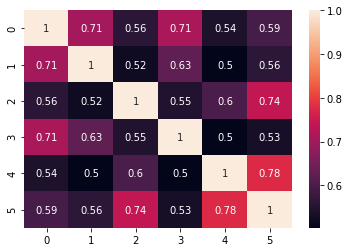

In [5]:
sns.heatmap(cosine_scores, annot=True);

In [6]:

#Find the pairs with the highest cosine similarity scores
pairs = []
for i in range(len(cosine_scores)-1):
    for j in range(i+1, len(cosine_scores)):
        pairs.append({'index': [i+1, j+1], 'score': cosine_scores[i][j]})

#Sort scores in decreasing order
pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)
pairs

[{'index': [5, 6], 'score': tensor(0.7762)},
 {'index': [3, 6], 'score': tensor(0.7400)},
 {'index': [1, 4], 'score': tensor(0.7134)},
 {'index': [1, 2], 'score': tensor(0.7061)},
 {'index': [2, 4], 'score': tensor(0.6263)},
 {'index': [3, 5], 'score': tensor(0.6003)},
 {'index': [1, 6], 'score': tensor(0.5947)},
 {'index': [2, 6], 'score': tensor(0.5612)},
 {'index': [1, 3], 'score': tensor(0.5599)},
 {'index': [3, 4], 'score': tensor(0.5468)},
 {'index': [1, 5], 'score': tensor(0.5400)},
 {'index': [4, 6], 'score': tensor(0.5326)},
 {'index': [2, 3], 'score': tensor(0.5215)},
 {'index': [2, 5], 'score': tensor(0.5047)},
 {'index': [4, 5], 'score': tensor(0.5029)}]

In [7]:
from modules.semantics import community_detection

In [19]:
data = pd.read_excel('Investments2020_.xlsx', engine='openpyxl')
data.head()

,Company Name,Last Financing Deal Type,Last Financing Deal Type 2,Last Financing Size,Last Financing Valuation,Total Raised,Last Financing Date,Primary Industry Group,Primary Industry Sector,All Industries,Verticals,HQ Location,Year Founded,Active Investors,Keywords,Website,Description,Primary Contact,Primary Contact Email
0,100Plus,Seed Round,Seed Round,15.0,NaN,15.00,2020-04-24,Healthcare Devices and Supplies,Healthcare,"Diagnostic Equipment*, Electronics (B2C), Medi...","Digital Health, TMT, Wearables & Quantified Self","San Francisco, CA",2016.0,"8VC, Ali Partovi, Ammunition Design Group, Ban...","heart monitor, heart monitoring device, remote...",www.100plus.com,Developer of remote patient monitoring platfor...,Ryan Howard,ryan@100plus.com
1,1upHealth,Early Stage VC,Series A,8.0,30.0,10.35,2020-02-05,Healthcare Technology Systems,Healthcare,"Medical Records Systems*, Other Healthcare Ser...","Digital Health, HealthTech, TMT","Boston, MA",2017.0,"Advisors.Fund, Boston Children's Hospital, Eni...","clinical hospital data, fhir api platform, hea...",www.1up.health,Developer of a healthcare data platform design...,Ritwik Sahu,rsahu@1up.health
2,Abacus.AI,Early Stage VC,Series B,22.0,102.0,40.25,2020-10-23,Commercial Services,Business Products and Services (B2B),"Business/Productivity Software, IT Consulting ...","Artificial Intelligence & Machine Learning, Bi...","San Francisco, CA",2019.0,"Avichal Garg, Coatue Management, Decibel Partn...","artificial intelligence platform, artificial i...",www.abacus.ai,Provider of an artificial intelligence platfor...,Bindu Reddy,bindu@abacus.ai
3,Able.,Later Stage VC,Series B,7.0,20.0,11.50,2020-02-10,Software,Information Technology,"Business/Productivity Software*, Human Capital...","HR Tech, Mobile, SaaS","Cleveland, OH",2014.0,"JumpStart, M25, North Coast Ventures, Ohio Inn...","hiring platform, interview screening, online h...",www.ableteams.com,Developer of a cloud-based onboarding and cand...,Gerald Hetrick,gerald@employstream.com
4,Abnormal Security,Early Stage VC,Series B,50.0,600.0,74.00,2020-11-18,Software,Information Technology,Network Management Software*,"Artificial Intelligence & Machine Learning, Cy...","San Francisco, CA",2018.0,"Greylock Partners, Menlo Ventures","business email security, email fraud security,...",www.abnormalsecurity.com,Developer of a cloud email security platform d...,Evan Reiser,evan@abnormalsecurity.com


In [23]:
descriptions = data.Description.to_list()
descriptions[:3]

["Developer of remote patient monitoring platform and devices intended to offer better care of elderly patients. The company's platform provides monitoring devices like blood pressure cuff, digital weight scale, emergency watch and blood glucose monitor that transmit data to physicians, enabling doctors and healthcare providers to spot signs, remotely monotor whether a person's health is worsening or treatment isn't working and provide the required care.",
 "Developer of a healthcare data platform designed for patients, providers and software developers to aggregate and share medical data. The company's platform tracks patient activity and automates secure data sharing from patients' electronic medical records while aggregating and sharing medical data and wearable device metrics, thus enabling patients to share data from disparate sources and improve healthcare outcomes.",
 "Provider of an artificial intelligence platform designed to help organizations create large-scale, real-time cu

In [25]:
%%time
#Compute embedding for list
embeddings = model.encode(descriptions, convert_to_tensor=True)
embeddings.shape

CPU times: user 24min 10s, sys: 42 s, total: 24min 52s
Wall time: 6min 17s


torch.Size([899, 1024])

In [86]:
groups = community_detection(embeddings, threshold=0.75, init_max_size=10)
print(groups)

[[5, 36, 43, 91, 144, 152, 167, 197, 206, 238, 286, 320, 333, 337, 358, 362, 370, 417, 437, 546, 568, 608, 620, 621, 630, 643, 655, 670, 751, 803, 807, 817, 876, 881], [15, 19, 50, 73, 109, 112, 116, 121, 142, 153, 216, 243, 276, 395, 396, 435, 462, 474, 504, 536, 567, 576, 577, 590, 635, 641, 887], [4, 34, 51, 66, 71, 87, 123, 150, 166, 251, 253, 508, 509, 552, 553, 560, 566, 606, 668, 692, 708, 731, 873, 891], [3, 46, 106, 158, 234, 285, 332, 428, 500, 584, 650, 658, 783, 814, 877], [56, 128, 233, 239, 294, 307, 330, 455, 511, 551, 752, 780, 827, 879], [141, 182, 222, 241, 411, 415, 438, 467, 473, 565, 574, 593, 682, 729], [301, 342, 367, 391, 430, 457, 484, 502, 626, 702, 719, 820], [80, 174, 242, 247, 313, 377, 591, 614, 706, 864]]


In [107]:
for x in data.iloc[groups[0]].Description:
    print(x)
    print()

Developer of an application performance platform designed to cut through the complexity of data operations. The company's platform offers information integration and data streaming services to permit clients to stream, collect, and process data, build data clusters and view actionable insights from the data as well as optimize workflow operations and capitalize on opportunities that are identified through analytics predictions, enabling clients to proactively manage performance, security, data quality and workflow.

Developer of a design-to-code product designed to deliver code fit for enterprise SaaS. The company's product utilizes algorithms to compose coding and facilitates designing websites and developing web-based applications for email and text message-based marketing, enabling developers and designers to convert the design to code automatically.

Developer of an application development platform intended to simplify distributed computing. The company's platform is based on an op

[autoreload of modules.semantics failed: Traceback (most recent call last):
  File "/home/eytan/miniconda/envs/vc-env/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/eytan/miniconda/envs/vc-env/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/eytan/miniconda/envs/vc-env/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/eytan/miniconda/envs/vc-env/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 783, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/eytan/Personal/VC_Investments_2020_Trends/modules/semantics.py", line 66, in <module>
    find_topk_related(embeddi